#Assignment 1 - MSDS 422-58, Winter 2021
# Jeffery A. Goldstein

In this assignement, we will look predict lung cancer mortality using predictive features in the scikit-learn library.

In [1]:
#imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from pandas_profiling import ProfileReport
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.base import clone


# Objective 0 - descriptive Summary of the Data


In [2]:
# this is a colab, so I have dropped the file in MyDrive
radonDF = pd.read_pickle('drive/MyDrive/MSDS_422/assign-1-radon-data.pickle')

# some exploratory stuff
print(radonDF.head())
print(radonDF.columns)
print(radonDF.dtypes)
print(radonDF.shape) #(2881, 12) there are 3000+ counties in the US.
print(len(list(set(radonDF['State'])))) # 46 -> -AK, HI, NH, NV 

    Code State            County  ...  Median HH Income  Mort Rank  Radon Rank
0   1001    AL    Autauga_County  ...             56.58       2523      1113.5
1  13103    GA  Effingham_County  ...             63.26       2409       270.5
2  13217    GA     Newton_County  ...             51.18       2281       974.5
3  13225    GA      Peach_County  ...             41.73       2366      1184.0
4  21077    KY   Gallatin_County  ...             47.68       2878       364.5

[5 rows x 12 columns]
Index(['Code', 'State', 'County', 'Lung Cancer Mortality', 'Radon', 'Obesity',
       'Age Over 65', 'Currently Smoke', 'Ever Smoke', 'Median HH Income',
       'Mort Rank', 'Radon Rank'],
      dtype='object')
Code                       int64
State                     object
County                    object
Lung Cancer Mortality    float64
Radon                    float64
Obesity                  float64
Age Over 65              float64
Currently Smoke          float64
Ever Smoke               flo



---
# Maps
We have geographic data, so why not display it geographically?
After some research, FIPS are invariant, but no longer in formal use. I was able to find longitude and latitude from [Dr. Benjamin Skinner](https://github.com/btskinner/spatial) on github.
: 


In [3]:
county_coords = pd.read_csv(
    'drive/MyDrive/MSDS_422/county_centers_btskinner.csv')
county_coords.head()


fips     clon00     clat00  ...    pclat00    pclon10    pclat10
0  1001 -86.577176  32.523283  ...  32.500323 -86.494165  32.500389
1  1003 -87.748260  30.592781  ...  30.565383 -87.762381  30.548923
2  1005 -85.331312  31.856515  ...  31.847869 -85.310038  31.844036
3  1007 -87.123243  33.040054  ...  33.025947 -87.127659  33.030921
4  1009 -86.554768  33.978461  ...  33.962601 -86.591491  33.955243

[5 rows x 9 columns]

*   fips     FIPS county code
*   clon00   geographic center of longitude in 2000
*   clat00   geographic center of latitude in 2000
*   clon10   geographic center of longitude in 2010
*   clat10   geographic center of latitude in 2010
*   pclon00  population weighted center of longitude 2000
*   etc. etc.

The data source peters out around 2000, so we'll stick with the numbers from 2000, although somewhat disturbed to know the counties are shifting.

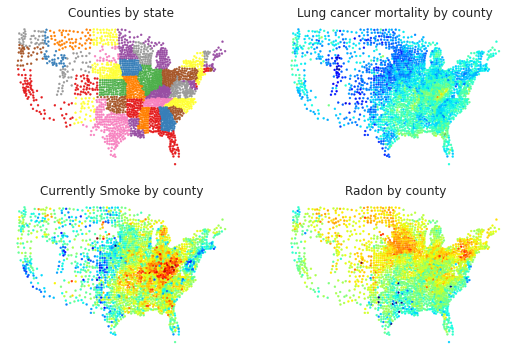

In [4]:
# change 'fips' to 'Code' to facilitate merging
county_coords = county_coords.rename(columns={"fips": "Code"})
radonDF['Code'] = radonDF['Code'].astype('int64')
radon_xy = radonDF.merge(county_coords, on = 'Code', how = 'left') # merging
#todo - figure out if we are missing coordinates for any of these
len(radon_xy) == len(radon_xy.dropna(subset = ['clon00','clat00'])) # true

# Let's visualize
plt.figure(figsize = [9,6])
# first visualization - where are the counties -> Nevada shaped hole
ax = plt.subplot(2,2,1)
ax.scatter(radon_xy['clon00'], radon_xy['clat00'], 
            c=radon_xy['State'].rank(),
            cmap = plt.get_cmap('Set1'),
           s=4)
ax.set_title('Counties by state')
plt.axis('off')

#lung cancer mortality by county; red = Bad
ax = plt.subplot(2,2,2)
ax.scatter(radon_xy['clon00'], radon_xy['clat00'],
           c=radon_xy['Lung Cancer Mortality'],
           cmap = plt.get_cmap('jet'),
           s=4)
ax.set_title('Lung cancer mortality by county')
plt.axis('off')

#smoking by county; red = more
ax = plt.subplot(2,2,3)
ax.scatter(radon_xy['clon00'], radon_xy['clat00'],
           c=radon_xy['Currently Smoke'],
           cmap = plt.get_cmap('jet'),
           s=4)
ax.set_title('Currently Smoke by county')
plt.axis('off')

#Household income by county; red = more
# the weird orange dot in the center of Appalachia is Williamson County, TN
ax = plt.subplot(2,2,4)
ax.scatter(radon_xy['clon00'], radon_xy['clat00'],
           c=np.log10(radon_xy['Radon'] + 0.01),
           cmap = plt.get_cmap('jet'),
           s=4)
ax.set_title('Radon by county')
plt.axis('off')

plt.show()

In [5]:
radonProfile=ProfileReport(radonDF)
radonProfile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Data profiling
What did we learn from the report:
1. 'Code' is unique --> Good
2. 'State' has a lot of repetitions, up to 247 for Texas --> OK
3. 'County' has a lot of unique values but many "Washington County"
--> 'County' is not a good index, hence FIPS
4. Lung Cancer Mortality is highly correlaed with Mort Rank -> Good
5. Radon is highly correlated with 'Radon Rank' --> Good
6. Radon is very unnormally distributed with a long right tail
7. There is one missing median HH income and hh income is right skewed.
8. Currently smoke and ever smoke are correlated -> good (expected relationship), but also bad (colinearity)

# Distributions and normalization
Having examined the distributions and found radon and HH income to be skewed, I will add transforms to try and get them normal.

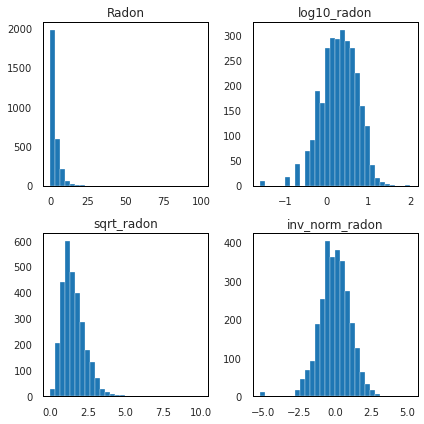

Radon             8.485467
log10_radon      -0.396361
sqrt_radon        1.397389
inv_norm_radon   -0.293540
dtype: float64

In [29]:
# normalizing radon - here are some options
# log10 is usually helpful, but the large number of 0 values makes it a poor
# choice for this dataset
# on option is to add a minute quantity to each value ('epsilon'?)
radonDF['log10_radon'] = np.log10(radonDF['Radon'] + 0.025)

radonDF['sqrt_radon'] = np.sqrt(radonDF['Radon']) # square root

# I've had luck with inverse normal transformations
# these map the rank of the sample onto the normal distribution
radonDF['inv_norm_radon'] = preprocessing.quantile_transform(
    np.array(radonDF['Radon']).reshape(-1,1),
    output_distribution='normal', copy = True)
comparisons = ['Radon', 'log10_radon', 'sqrt_radon', 'inv_norm_radon']

plt.figure(figsize=(6,6))
for column, sub in zip(comparisons, range(1,5)):
  ax = plt.subplot(2,2,sub)
  ax.hist(radonDF[column], bins=30)
  ax.set_title(column)
plt.tight_layout()
plt.show()
radonDF[['Radon', 'log10_radon', 'sqrt_radon', 'inv_norm_radon']].skew()

Normalizing household income
<p>
This is very similar to radon.

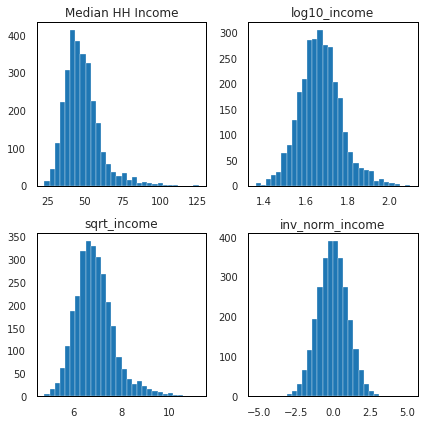

Median HH Income    1.339536
log10_income        0.359901
sqrt_income         0.821428
inv_norm_income    -0.007648
dtype: float64

In [28]:
# normalizing household income - here are some options
# log10 is usually helpful
radonDF['log10_income'] = np.log10(radonDF['Median HH Income'])

radonDF['sqrt_income'] = np.sqrt(radonDF['Median HH Income']) # square root

# I've had luck with inverse normal transformations
# these map the rank of the sample onto the normal distribution
radonDF['inv_norm_income'] = preprocessing.quantile_transform(
    np.array(radonDF['Median HH Income']).reshape(-1,1),
    output_distribution='normal', copy = True)
comparisons = ['Median HH Income', 
               'log10_income', 
               'sqrt_income', 
               'inv_norm_income']

plt.figure(figsize=(6,6))
for column, sub in zip(comparisons, range(1,5)):
  ax = plt.subplot(2,2,sub)
  ax.hist(radonDF[column], bins=30)
  ax.set_title(column)
plt.tight_layout()
plt.show()
radonDF[comparisons].skew()

# Smoking status
As noted above, 'Currently Smoke' and 'Ever Smoke' are correlated. This is logical in that current smokers are a subset of ever smokers. However, it raises problems with colinearity.

It has been suggested that smoking status can be managed in epidemiological studies by categorizing people as never smokers, current smokers, and ex-smokers https://doi.org/10.1093/aje/kwf122.

<p>

Let us define 'ex-smokers' as ever smokers that are not current smokers. We could argue that the proportion of ex-smokers is equal to the proportion of ever smokers minus the proportion of current smokers (I am not sure this is completely accurate, but is likely close for this problem).

In [8]:
radonDF['Ex Smoker'] = radonDF['Ever Smoke'] - radonDF['Currently Smoke']
radonDF[['Ever Smoke', 'Currently Smoke', 'Ex Smoker']].corr()

Ever Smoke  Currently Smoke  Ex Smoker
Ever Smoke         1.000000         0.722805   0.512956
Currently Smoke    0.722805         1.000000  -0.222443
Ex Smoker          0.512956        -0.222443   1.000000

If we use a model with Ever Smoke and Currently Smoke, we will be fighting with two variables with a Pearson correlation of 0.72.
<p>
If instead we use a model with Currently Smoke and Ex Smoke, we will have a correlation of only -0.22. -> Better.

# Objective 1 Linear regression models
We will train 4 linear regression models to predict lung cancer mortality. We will begin with a fresh reload and a train/test split

In [9]:
radonDF = pd.read_pickle('drive/MyDrive/MSDS_422/assign-1-radon-data.pickle')

# code is actually a species of categorical variable, so we will turn it into a
# string and then ignore it
radonDF.Code=radonDF.Code.astype('str',copy=True)

# as noted above, this de-colinearizes the smoking variables
radonDF['Ex Smoker'] = radonDF['Ever Smoke'] - radonDF['Currently Smoke']

# get features - Mort Rank is derived from Lung Cancer Mortality, so get
# rid of it here
x = radonDF.drop(['Lung Cancer Mortality', 'Mort Rank'], axis = 1)
y = radonDF['Lung Cancer Mortality']

#train-test split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, 
                              test_size = 0.2, random_state = 21)

# Define a pipeline for data processing
We want to build something reusable that we can use to transform the data into something the regressions like.

In [10]:
#start with a column transformer. This applies specific transformations to 
# different columns of the dataframe

ct = ColumnTransformer(
  [ # as discussed above, we want an inverse normal transform of radon and 
   # median HH income as these are abnormally distributed
      ('inv_norm', preprocessing.QuantileTransformer(
      output_distribution='normal'), ['Radon', 'Median HH Income']),
   # code is not useful and radon level subsumes radon rank, so these go
   # any column not mentioned is dropped, but is seems helpful to be explicit   
   ('drop', 'drop', ['Code', 'Radon Rank', 'Ever Smoke', 'County']),
  # the remaining values get scaled using the standard scaler
   ('scaler', preprocessing.StandardScaler(), ['Obesity', 'Age Over 65', 
                                 'Currently Smoke', 'Ex Smoker']),
   # State is a potentially interesting categorical variable, so we will one-hot
   # encode it. A more sophisticated model might also encode U.S. regions
   # in a similar way
   ('one hot', preprocessing.OneHotEncoder(), ['State'])
  ])

# we'll use pipeline to join the column transformer with a simple imputer
# there's a missing HH income value in my training data, and this will fill it
# with the median of the column. It makes sense this on all columns since 
# future data may have missing values elsewhere.
data_pipe = Pipeline([('xform', ct), 
                      ('fillna', SimpleImputer(strategy = 'median'))])

# we will fit the pipeline using xtrain - this sets norms for regularization
# and normalizing. Calling fit_transform fits the pipeline to the data and
# returns the transformed data
xtrain_x = data_pipe.fit_transform(xtrain)

# conversely, we to transform the test data, but not re-fit the transformer
xtest_x = data_pipe.transform(xtest)

#Regressions
We'll define and fit 4 related regressions
* vanilla linear regression
* lasso regression - linear regression with L1 normalization
* ridge regression - linear regression with L2 normalization
* elastic net - linear regression with a mix of L1 and L2 normalization

The regularizations penalize a proposed model based on the sum of the absolute value of the coefficients (L1), the square root of the sum of squares of the coefficients (L2), or a mix (elastic). The size of the penalty (for all 3) and the mix of L1 and L2 (for elastic) are <i>hyperparameters</i>, that is, parameters about the regression that are not optimized within the regression. We will use the defaults here, but I sense a grid optimization problem coming later.


In [11]:

# we begin by initializing a linear regression object
LR = LinearRegression()
LR.fit(xtrain_x, ytrain) # fit trains the regression on the training data
print(f'Model intercept estimate: {LR.intercept_:5.3f}')
print(f'Model estimated coefficients: {LR.coef_}')

Model intercept estimate: 77.278
Model estimated coefficients: [ -2.40043707  -0.93458542   2.43014363  -3.52576405   5.84359828
   3.73660758  -0.4195284   10.14384134 -16.01399596   5.20290917
 -12.48440404   3.16212222  13.73920343  16.92521402   7.62249898
  -6.11574552 -20.06454994   2.21636213   1.87097574  -3.65071155
  15.38024373  11.95068739   5.9455266   15.14277115   7.63842345
  -5.39368281 -15.04702213   1.67766669   2.64612596  -3.18179306
   3.60833206 -13.85249355 -11.73173666  11.09692019 -13.72868038
   5.51512266   1.40166777   4.61269728   1.14238893  -3.7009308
   6.73840911  -0.34726913  -8.67559441   8.01033852   4.47230565
 -25.58069033  10.64529098  -1.55631035   0.5990579  -14.93685733
   6.42129892  -9.04640564]


That's a lot of coefficients. What do they mean? <p>
ColumnTransformer puts the array columns in the order, so these are Radon (-2.4), Median HH Income (-0.93), Obesity (+2.4), Age Over 65 (-3.5), Currently Smoke (+5.8), Ex Smoker (+3.7), and then the one-hot variables for the states. These coefficients have all been normalized, so interpretation is somewhat challenging. I would explain this by saying that, for every standard deviation the percent of current smokers in a county is above the national mean, the lung cancer mortality goes up by 5.8.
<p>
If I were explaining it to a politician, I might use different words, or even possibly a model where smoking is not scaled in order to make it more explainable.
<p>
The decreased lung cancer mortality with increasing radon is surprising. My first thought would be a coding error, but if we look at the maps, the areas of high radon really don't line up with the areas of high lung cancer mortality. One plausible interpretation is that smoking is a much stronger risk factor and indeed it lines up better on the maps. 

The next step is to evaluate the regression

In [12]:
# we are calculating two metrics of accuracy - R^2 and mean squared error
# we will calculate both metrics for the training and testing set
# we exprect the testing set to be somewhat worse, but hopefully not too much

# first, we'll generate the predictions from the model for each data set
train_preds = LR.predict(xtrain_x)
test_preds = LR.predict(xtest_x)

# R^2, the regression score, is related to the proportion of variance in the
# data that is explained by the regression. 
r2_train = metrics.r2_score(ytrain, train_preds)
r2_test = metrics.r2_score(ytest, test_preds)

# Mean squared error is a measure of error for each point
mse_train = metrics.mean_squared_error(ytrain, train_preds)
mse_test = metrics.mean_squared_error(ytest, test_preds)
print(f'Model score (r2) on training: {r2_train:5.3f}')
print(f'Model score (r2) on testing: {r2_test:5.3f}')
print(f'Model mean squared error on training: {mse_train:5.3f}')
print(f'Model mean squared error on testing: {mse_test:5.3f}')

Model score (r2) on training: 0.645
Model score (r2) on testing: 0.627
Model mean squared error on training: 110.499
Model mean squared error on testing: 116.264


This seems like a reasonable loss of accuracy. The fact that it's >0 suggests there is not a data leak.
<p>
The next step is to use the regressions with regularization.

In [13]:
# ridge regression
ridge_R = Ridge() #initialize
ridge_R.fit(xtrain_x, ytrain) # train the regression

# Lasso regression
lasso_R = Lasso() # initialize
lasso_R.fit(xtrain_x, ytrain) # train lasso

# elastic regression
elastic_R = ElasticNet() # initialize
elastic_R.fit(xtrain_x, ytrain)

# now let us compare them (and include the original linear regression)
print(f'LR intercept estimate: {LR.intercept_:5.3f}')
print(f'Ridge intercept estimate: {ridge_R.intercept_:5.3f}')
print(f'Lasso intercept estimate: {lasso_R.intercept_:5.3f}')
print(f'Elastic intercept estimate: {elastic_R.intercept_:5.3f}')
print(f'Mean of the data set: {np.mean(ytrain):5.3f}')

LR intercept estimate: 77.278
Ridge intercept estimate: 77.103
Lasso intercept estimate: 78.148
Elastic intercept estimate: 78.147
Mean of the data set: 78.174


The intercept should be pretty close to the dataset mean.

In [14]:
# now we will compare the coefficients (only the first 10 - mercy)
print(f'LR estimated coefficients: {LR.coef_[0:10].astype(int)}')
print(f'Ridge coefficients:        {ridge_R.coef_[0:10].astype(int)}')
print(f'Lasso coefficents:         {lasso_R.coef_[0:10].astype(int)}')
print(f'Elastic coefficients:      {elastic_R.coef_[0:10].astype(int)}')

LR estimated coefficients: [ -2   0   2  -3   5   3   0  10 -16   5]
Ridge coefficients:        [ -2   0   2  -3   5   3   0  10 -13   5]
Lasso coefficents:         [-4  0  1 -1  7  0  0  0  0  0]
Elastic coefficients:      [-3  0  2 -1  4  0  0  0  0  0]


- Ridge is not doing much (could crank up the hyperparameters)
- Lasso is getting rid of a lot of variables (as intended)
- Elastic is behaving mostly like lasso (cound change hyperparameters)

In [15]:
# the next step is to look at the scores
for name, reg in zip(['ridge', 'lasso', 'elastic'],
                     [ridge_R, lasso_R, elastic_R]):
  train_preds = reg.predict(xtrain_x)
  test_preds = reg.predict(xtest_x)
  r2_train = metrics.r2_score(ytrain, train_preds)
  r2_test = metrics.r2_score(ytest, test_preds)
  mse_train = metrics.mean_squared_error(ytrain, train_preds)
  mse_test = metrics.mean_squared_error(ytest, test_preds)

  print(f'{name} training r2: {r2_train:5.3f}, testing r2: {r2_test:5.3f}')
  print(f'{name} training mse: {mse_train:5.3f}, testing mse: {mse_test:5.3f}')

ridge training r2: 0.645, testing r2: 0.628
ridge training mse: 110.664, testing mse: 115.885
lasso training r2: 0.437, testing r2: 0.448
lasso training mse: 175.396, testing mse: 172.102
elastic training r2: 0.403, testing r2: 0.408
elastic training mse: 185.949, testing mse: 184.347


lasso and elastic have worse r^2, but actually improve with the testing set (?).

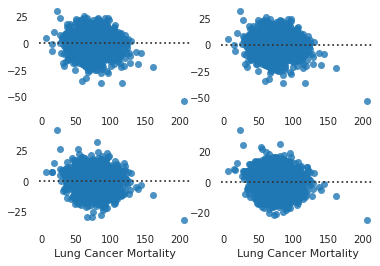

In [16]:
# the next step is to use visualization and residual plots to explain the data
# we'll use the 'residplot' function from Seaborn, which plots the residual
# (y_pred - y_actual) vs. y_actual.

# visualizations - residual plots
fig, axs = plt.subplots(ncols=2, nrows = 2)
sns.residplot(x=ytrain, y=LR.predict(xtrain_x), ax = axs[0,0], label = 'LR')
sns.residplot(x=ytrain, y=ridge_R.predict(xtrain_x),
              ax = axs[0,1], label = 'ridge')
sns.residplot(x=ytrain, y=lasso_R.predict(xtrain_x),
              ax = axs[1,0], label = 'lasso')
sns.residplot(x=ytrain, y=elastic_R.predict(xtrain_x),
              ax = axs[1,1], label = 'elastic')


There seem to be some issues with underestimating high lung cancer mortalities, moreso in the LR and ridge regressions, but they all miss on the highest mortality counties.

In [17]:
# and what might those counties be?
rs = radonDF.sort_values(by = 'Lung Cancer Mortality')
rs.tail()

Code State           County  ...  Mort Rank  Radon Rank  Ex Smoker
1087  54045    WV     Logan_County  ...       2877       896.5      22.35
4     21077    KY  Gallatin_County  ...       2878       364.5      26.70
1585  21193    KY     Perry_County  ...       2879       811.5      20.05
1606  21147    KY  McCreary_County  ...       2880       974.5      19.40
752   12125    FL     Union_County  ...       2881       460.5      16.50

[5 rows x 13 columns]

Union County, Florida - 4th poorest county in the U.S., highest death rate (in 2017, source: [wikipedia](https://en.wikipedia.org/wiki/Union_County,_Florida))

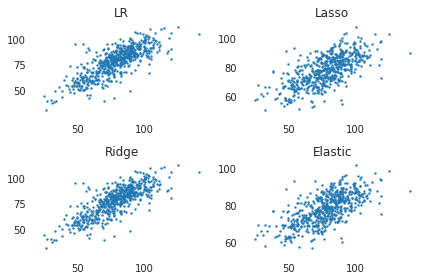

In [18]:
# lets examine the distribution of predicted vs. actual mort in the test set
fig, axs = plt.subplots(ncols = 2, nrows = 2)
ax = axs[0,0]
ax.scatter(ytest, LR.predict(xtest_x), s = 4, label = 'LR')
ax.set_title('LR')
ax = axs[1,0]
ax.scatter(ytest, ridge_R.predict(xtest_x), s = 4, label = 'Ridge')
ax.set_title('Ridge')
ax = axs[0,1]
ax.scatter(ytest, lasso_R.predict(xtest_x), s = 4, label = 'Lasso')
ax.set_title('Lasso')
ax = axs[1,1]
ax.scatter(ytest, elastic_R.predict(xtest_x), s= 4, label = 'Elastic')
ax.set_title('Elastic')
plt.tight_layout()

What is there to say? LR and Ridge cover more of the space, hence their higher R^2. There's a lot of noise.

# Objective 2 - Binary classification

We will train and validate models for predicting which counties have above average rates of mortality.
* Binary logistic regression with regularization.
* Ridge classification

We will validate using k fold cross-validation with 10 folds.


In [19]:
# reload a fresh copy of the dataset
radonDF = pd.read_pickle('drive/MyDrive/MSDS_422/assign-1-radon-data.pickle')

# as noted above, this de-colinearizes the smoking variables
radonDF['Ex Smoker'] = radonDF['Ever Smoke'] - radonDF['Currently Smoke']

# median HH income is still missing for Shannon County SD (see above).
# we could fill it with data from adjacent counties, or median, but because
# we are doing cross-validation, there is a risk of data leak from fold to fold

misser=radonDF.isna().sum(axis=1)
radonDF2=radonDF.loc[misser==0,:].copy()
missed = radonDF.loc[misser==1,:].copy()
missed # Shannon County, SD

# as above we'll do one hot encoding by state, unlike above, 
# we're doing it outside of a pipeline so we use pandas
radonDF2 = pd.get_dummies(radonDF2, columns = ['State'])

# we will define high-risk counties as those wehre lung cancer mortality is
# greater than 79.48
radonDF2['HiRisk']=np.where(radonDF2['Lung Cancer Mortality']>79.48,1,0)

radonDF2.columns

Index(['Code', 'County', 'Lung Cancer Mortality', 'Radon', 'Obesity',
       'Age Over 65', 'Currently Smoke', 'Ever Smoke', 'Median HH Income',
       'Mort Rank', 'Radon Rank', 'Ex Smoker', 'State_AL', 'State_AR',
       'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DE', 'State_FL',
       'State_GA', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS',
       'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI',
       'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND',
       'State_NE', 'State_NJ', 'State_NM', 'State_NY', 'State_OH', 'State_OK',
       'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN',
       'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI',
       'State_WV', 'State_WY', 'HiRisk'],
      dtype='object')

In [20]:
# defining our data sets
y=radonDF2.HiRisk.to_numpy(copy=True)
x=radonDF2.drop(['Lung Cancer Mortality', 'Mort Rank', 'HiRisk',  # data leak
                'Code', 'County'], # objects / categories we aren't one_hotting
                axis = 1).to_numpy(copy=True)

kf=StratifiedKFold(n_splits=10,shuffle=True, random_state=21)

logReg=LogisticRegression(penalty="l2",n_jobs=-1,verbose=0)
norm = preprocessing.StandardScaler()

resList=[] # A list to hold fold dicts of metrics
for train, test in kf.split(x,y): # fold loop  
  norm_batch = clone(norm).fit(x[train]) # clone - we are making a model for just this fold 
  xt_norm = norm_batch.transform(x[train])
  xtest_norm = norm_batch.transform(x[test])
  logR=clone(logReg).fit(xt_norm,y[train])
  trainPred=logR.predict(xt_norm) # HiRisk prediction, 1 or 0, training data
  trainProb=logR.predict_proba(xt_norm)[:,1] # Predicted prob(HiRisk=1), training data
  testPred = logR.predict(xtest_norm) # HiRisk testing data
  testProb = logR.predict_proba(xtest_norm)[:,1] # hi risk probabilities
  accTrain=accuracy_score(y[train], trainPred)
  accTest=accuracy_score(y[test], testPred)
  aucTrain=roc_auc_score(y[train],trainProb)
  aucTest =roc_auc_score(y[test], testProb)
  precisionTrain = precision_score(y[train], trainPred)
  precisionTest = precision_score(y[test], testPred)
  recallTrain = recall_score(y[train], trainPred)
  recallTest = recall_score(y[test], testPred)
  resList.append(
    {'testAcc':accTest,
     'trainAcc':accTrain,
     'testAUC':aucTest,
     'trainAUC':aucTrain,
     'testPrecision':precisionTest,
     'trainPrecision':precisionTrain,
     'testRecall':recallTest,
     'trainRecall':recallTrain
    })

logResDF=pd.DataFrame(resList)
print('Summary Across Folds')
logResDF.describe()

Summary Across Folds


testAcc   trainAcc    testAUC  ...  trainPrecision  testRecall  trainRecall
count  10.000000  10.000000  10.000000  ...       10.000000   10.000000    10.000000
mean    0.810069   0.819946   0.890495  ...        0.797288    0.836969     0.850231
std     0.022801   0.003065   0.014753  ...        0.003661    0.021204     0.003078
min     0.774306   0.816358   0.865232  ...        0.791393    0.809859     0.844706
25%     0.796007   0.817612   0.887227  ...        0.795216    0.823007     0.848942
50%     0.815972   0.819830   0.893123  ...        0.796481    0.833908     0.850588
75%     0.826389   0.821084   0.899576  ...        0.799521    0.844796     0.852745
max     0.840278   0.826003   0.908354  ...        0.804428    0.880282     0.854232

[8 rows x 8 columns]

# K-folds, another way
cross_validate allows for k-fold cross vaidation in a single line by passing in regressions.

In [21]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import SCORERS
# vs. cross_val_score, cross_validate allows multiple metrics

# adding a scaler was helful when doing cross validation by hand
# the way to do this in one line CV is to put it in a pipeline
logPipe = Pipeline([('scaler', preprocessing.StandardScaler()), 
                        ('logReg', logReg)])


logRegCV=cross_validate(clone(logPipe),x, y, cv=10, return_train_score=True,
    scoring=('accuracy','roc_auc', 'precision', 'recall')) # to name a few
print(f'Summary Across Folds')
pd.DataFrame(logRegCV).iloc[:,2:].describe() #test accuracy much higher std


Summary Across Folds


test_accuracy  train_accuracy  ...  test_recall  train_recall
count      10.000000       10.000000  ...    10.000000     10.000000
mean        0.745139        0.823071  ...     0.750385      0.849682
std         0.133179        0.011179  ...     0.245458      0.009918
min         0.555556        0.810185  ...     0.297872      0.829804
25%         0.644097        0.813368  ...     0.757042      0.843364
50%         0.730903        0.824460  ...     0.830986      0.851039
75%         0.880208        0.828607  ...     0.903169      0.856863
max         0.899306        0.844907  ...     0.978873      0.864420

[8 rows x 8 columns]

I note that the test accuracy here is lower (0.75 vs. 0.81) with higher std (0.13 vs. 0.02) than that doing this by hand with Stratified K-folds. I'm not sure why. I considered that cross_validate might not use stratification - not so. Per [docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate), stratification is used whenever a binary classification is performed.

# Ridge classification
Ridge classification treats the problem as a regression with output values between 1 and -1.

In [22]:
# we'll start from x and y as defined above - the other option is to copy/paste
# block 27
# this also means we're resuing kf and norm from above

from sklearn.linear_model import RidgeClassifier

ridgeClf = RidgeClassifier()
ridge_resList=[] # A list to hold fold dicts of metrics

for train, test in kf.split(x,y): # fold loop  
  norm_batch = clone(norm).fit(x[train])
  xt_norm = norm_batch.transform(x[train])
  xtest_norm = norm_batch.transform(x[test])
  rClf = clone(ridgeClf).fit(xt_norm,y[train]) # clone makes a deep copy before fitting - prevents leak between folds
  trainPred=rClf.predict(xt_norm) # HiRisk prediction, 1 or 0, training data
  trainDec=rClf.decision_function(xt_norm) # Decision function output -1 to 1
  trainProb = np.exp(trainDec) / np.sum(np.exp(trainDec)) # Softmax to get this 0 - 1
  testPred = rClf.predict(xtest_norm) # HiRisk testing data
  testDec = rClf.decision_function(xtest_norm) # ditto decision -> prob for test
  testProb = np.exp(testDec) / np.sum(np.exp(testDec)) # ditto Softmax
  accTrain=accuracy_score(y[train], trainPred)
  accTest=accuracy_score(y[test], testPred)
  aucTrain=roc_auc_score(y[train],trainProb)
  aucTest =roc_auc_score(y[test], testProb)
  precisionTrain = precision_score(y[train], trainPred)
  precisionTest = precision_score(y[test], testPred)
  recallTrain = recall_score(y[train], trainPred)
  recallTest = recall_score(y[test], testPred)
  ridge_resList.append(
    {'testAcc':accTest,
     'trainAcc':accTrain,
     'testAUC':aucTest,
     'trainAUC':aucTrain,
     'testPrecision':precisionTest,
     'trainPrecision':precisionTrain,
     'testRecall':recallTest,
     'trainRecall':recallTrain })

ridgeResDF=pd.DataFrame(ridge_resList)
print('Summary Across Folds - Ridge Classifier')
ridgeResDF.describe()

Summary Across Folds - Ridge Classifier


testAcc   trainAcc    testAUC  ...  trainPrecision  testRecall  trainRecall
count  10.000000  10.000000  10.000000  ...       10.000000   10.000000    10.000000
mean    0.807292   0.817091   0.887239  ...        0.784045    0.855349     0.867091
std     0.024014   0.003225   0.014993  ...        0.003351    0.016822     0.006472
min     0.760417   0.814043   0.856888  ...        0.779494    0.816901     0.858934
25%     0.800347   0.815297   0.881536  ...        0.780981    0.846831     0.863752
50%     0.807292   0.815972   0.887613  ...        0.784112    0.858655     0.866275
75%     0.820312   0.818191   0.895782  ...        0.786672    0.865960     0.867529
max     0.850694   0.824460   0.909560  ...        0.788462    0.873239     0.883137

[8 rows x 8 columns]

#Objective 3: Model Tuning
We will adjust the logistic regression model by varying the regularization.


In [23]:
# we start importing the appropriate function from sklearn
from sklearn.model_selection import GridSearchCV

# logistic regression uses C, rather than alpha.
# Lower C = Higher alpha = more regularization
# we'll define our parameter grid
# because logReg is buried within the pipeline, we use "logReg__C" as the key
parms = {"logReg__C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}

# GridSearchCV takes input similar to cross_validate, so we'll use the same
# pipeline - scaler followed by logistic regression
logPipe = Pipeline([('scaler', preprocessing.StandardScaler()), 
                        ('logReg', logReg)])

# initialize gridsearchcv 
logParmCV = GridSearchCV(logPipe,n_jobs=-1,verbose=0,
                      refit=True, # will use the best metrics to recall the set
                      cv = 10, # number of folds
                      scoring="accuracy", # as above we could submit several
                      return_train_score=True,
                      param_grid=parms) # defined above

# fit using categorical data
logParmFit = logParmCV.fit(x,y)

In [24]:
# now to check the results
print(f'Summary of Grid Search')
cols=['param_logReg__C','mean_train_score','std_train_score',
'mean_test_score','std_test_score']
pd.DataFrame(logParmFit.cv_results_)[cols].sort_values(by='param_logReg__C',
ascending=False)

Summary of Grid Search


param_logReg__C  mean_train_score  ...  mean_test_score  std_test_score
6              10          0.823187  ...         0.746528        0.126962
5               1          0.823071  ...         0.745139        0.126345
4             0.1          0.822917  ...         0.747569        0.124003
3            0.01          0.818287  ...         0.752431        0.120452
2           0.001          0.808565  ...         0.761458        0.126981
1          0.0001          0.796991  ...         0.762500        0.138317
0           1e-05          0.588966  ...         0.563889        0.084941

[7 rows x 5 columns]

Decreasing C, i.e. increasing regularization from 1e-0 to 1e-4 decreases the training score while increasing the test score. This is evidence of overfitting at the highest level of C. When we go from 1e-4 to 1e-5, the training and test scores get abruptly worse. We have traded too much variance for too much bias. <p>
So the best C is....

In [25]:
# Best model parameters
logParmFit.best_params_

{'logReg__C': 0.0001}

#Objective 4: Plot an ROC Curve, Produce a Confusion Matrix
Receiver operator characteristic (ROC) curve and confusion matrix are two ways to look at a classifier. <p>
Logistic regression as output gives a log-odds (a.k.a. logit, a.k.a. t). Log-odds can be transformed into a probability (ranging from 0-1). Typically we are making a yes/no prediction and will call "yes" if the probability is over 0.5, otherwise "no".
<p>
With ROC, we look at the impact of varying the threshold probability between 0 and 1. We could look at accuracy vs. threshold, but it is more useful to think of accuracy as 2 components -> calling positives positive (True positive rate / Sensitivity  / Recall) and not calling negatives positive (False positive rate). In ROC, we look at the relationship between True Positive Rate and False Positive Rate as we vary the threshold.
<p>
With a very low threshold, the true positive rate will be very high, but so will the false positive rate. With a very high threshold, the false positive rate will be very low, but so will the true positive rate.
<p>
ROC lets us 1. generate an overall score (v. important) and 2. evaluate the threshold. Depending on the problem, we may be more tolerant of false positives or false negatives. For example, if we are going to [accuse people of welfare fraud](https://https://en.wikipedia.org/wiki/Childcare_benefits_scandal), we want to be very very sure.

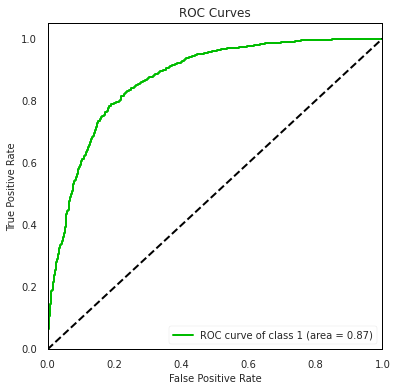

In [26]:
import scikitplot as skplt #scikit plot has convenient functions for this
matplotlib.rc('axes',lw=1,edgecolor='black')

yPredProb=logParmFit.predict_proba(x) # predicted probabilities
yPredProb.shape # (2880, 2); 2880 counties, yes/no
skplt.metrics.plot_roc(y, yPredProb,
classes_to_plot=1,
plot_micro=False, # for analyzing multiclass classifications
plot_macro=False, # for analyzing multiclass classifications
figsize=(6,6))

ROC AUC is 0.87 - pretty good. A coin flip (dashed line) would give you an AUC of 0.5. The curve is pretty smooth, but sometimes there's an angle where large variations in (for instance) FPR happen with a single TPF, in which case we would favor a threshold at the 'corner'.

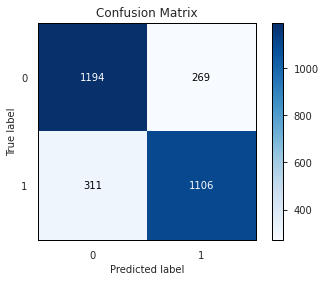

In [27]:
# the next step is to generate a confusion matrix
# covering all options and their frequency.
# this is useful for looking at the kinds of errors
# the classifier makes, for example do we see lots of false
# positives, etc.
yPred=logParmFit.predict(x) # get values
skplt.metrics.plot_confusion_matrix(y,yPred) # skplt does the work

This is pretty good. Lots of true negatives (top left) and true positives (lower right). Few false positives (FP, top right) and false negatives (FN, misses, bottom left). The number of FP and FN are about equal, so the model is neither too quick nor too hesitant to call a positive. 
<p>
While not explicitly addressed above, we can also see that about 1/2 the counties are HiRisk. If that were not the case, we could introduce weighting or use a normalized confusion matrix.